In [31]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn import plotting
import random
import numpy as np
import json 
from utils import OUT_PATH, ExcludSubj, GetInfo ,TFRmEvents, FindRegion

tfr_path = OUT_PATH+ '/Data_shortWOBS'
subj_included = [file.replace('_TFRtrials.p', '') for file in os.listdir(tfr_path) if file[-len('TFRtrials.p'):] == 'TFRtrials.p']
subj_included = ExcludSubj(subj_included, data_path=tfr_path)
coord, areas, elect_list, subj_list = GetInfo(subj_included, data_path=tfr_path)
print(f"Subject Nbr is {len(subj_included)}")

plt.style.use('seaborn-v0_8-dark')

Subject Nbr is 30


## PRES DATA INTRO

In [32]:
df= pd.DataFrame()
df['area'] = [a[0] for a in areas]
df.loc[:,['x', 'y', 'z']] = coord
df.loc[:, 'region'] = df.loc[:, 'area'].apply(lambda x : FindRegion(x))
df = df.fillna('NON')
df['subj'] = subj_list
mapper = {reg:num for num, reg in zip(np.arange(np.unique(df['region'].values).shape[0]), np.unique(df['region'].values))}
df.loc[:, 'region_code'] = df.loc[:, 'region'].map(mapper)
mapper = {subj:num for num, subj in zip(np.arange(np.unique(df['subj'].values).shape[0]), np.unique(df['subj'].values))}
df.loc[:, 'subj_code'] = df.loc[:, 'subj'].map(mapper)
count_region = df['region'].value_counts()

for r in np.unique(df.region) :
    df.loc[df[df['region'] == r].index, 'count_region'] = count_region[r]

# ADJUSTE THE COORDS TODO
for i, row in df.iterrows() : 
    if abs(row.x) > 100 :
        df.loc[i, ['x', 'y', 'z']] =  df.loc[i, ['x', 'y', 'z']]/1000

In [33]:
# Count per area
df_count_region = pd.DataFrame(df['region'].value_counts())
for i, row in df_count_region.iterrows() :
    df_count_region.loc[i, ['x', 'y', 'z']] = df.loc[df[df['region'] == i].index, ['x', 'y', 'z']].median()
    df_count_region.loc[i, 'region_code'] = df.loc[df[df['region'] == i].index[0], 'region_code']
    
df_count_region = df_count_region.reset_index()

In [34]:
coord_1 = df_count_region[['x', 'y', 'z']].values
cmap = plt.get_cmap('tab20')
df_count_region['index_norm'] = (df_count_region['region_code'] - df_count_region['region_code'].min())/(df_count_region['region_code'].max() - df_count_region['region_code'].min()) 
colors_1 = np.array([cmap(code) for code in df_count_region['index_norm']])
marker_size_1 =df_count_region['count']
labels_1 = [area + ' ' + str(c) for area, c in zip(list(df_count_region['region'].values), df_count_region['count'])]

coord_2 = df[['x', 'y', 'z']].values
cmap = plt.get_cmap('tab20')
df['index_norm'] = (df['region_code'] - df['region_code'].min())/(df['region_code'].max() - df['region_code'].min()) 
colors_2 = np.array([cmap(code) for code in df['index_norm']])
marker_size_2 = [5]*len(colors_2)
labels_2 = ['']*len(colors_2)

coord = np.concat([coord_1, coord_2])
colors = np.concat([colors_1, colors_2])
marker_size= np.concat([marker_size_1, marker_size_2])
labels = labels_1 + labels_2

In [35]:
view = plotting.view_markers(coord,marker_color=colors,marker_size=marker_size,title=f'Channels per region',title_fontsize=25, marker_labels=labels)
view.open_in_browser()
view = plotting.view_markers(coord_1,marker_color=colors_1,marker_size=marker_size_1,title=f'Channels per region',title_fontsize=25, marker_labels=labels_1)
view.open_in_browser()


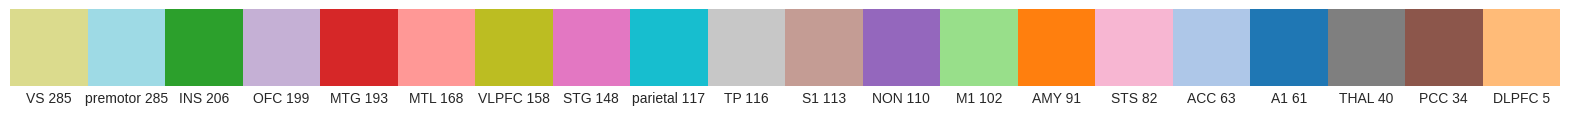

In [36]:
import matplotlib as mpl
import numpy as np

cmap = mpl.colors.ListedColormap(colors_1)
bounds = np.arange(len(labels_1) + 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(len(labels_1), 1))

# Create colorbar as a legend
cb = mpl.colorbar.ColorbarBase(
    ax, cmap=cmap, norm=norm, boundaries=bounds,
    ticks=(bounds[:-1] + bounds[1:]) / 2,    # center ticks
    orientation='horizontal'
)

cb.ax.set_xticklabels(labels_1)
plt.show()


In [13]:
coord = df[['x', 'y', 'z']].values
cmap = plt.get_cmap('tab20')
colors = np.array([cmap(code) for code in df['index_norm']])
view = plotting.view_markers(coord,marker_color=colors,marker_size=5,title=f'Channels per region',title_fontsize=25)
view.open_in_browser()

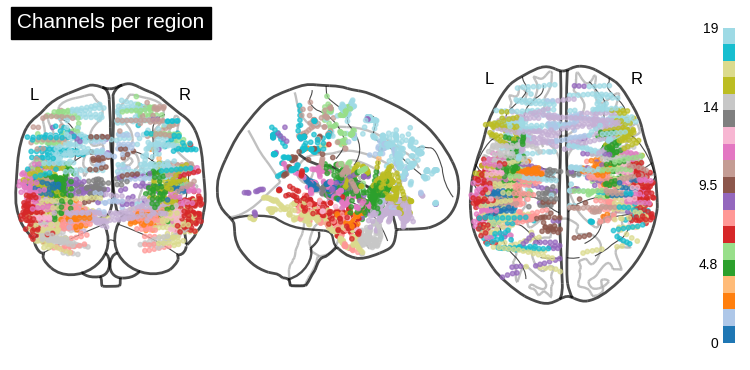

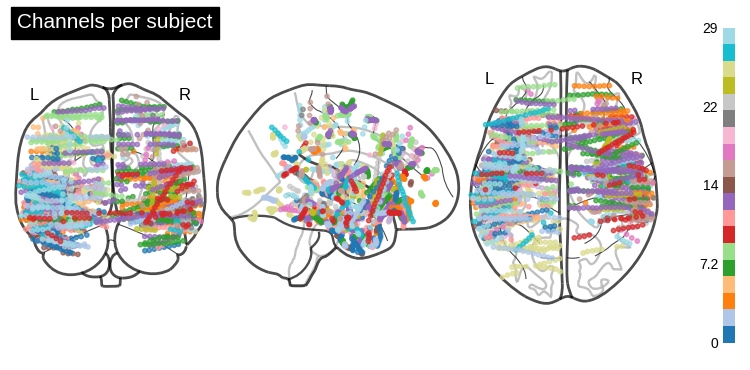

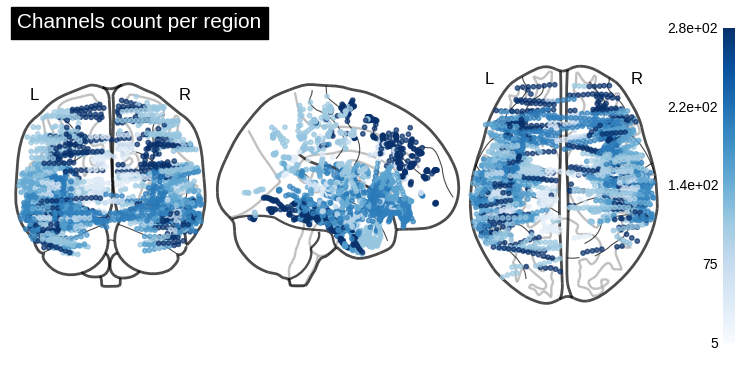

In [14]:
fig0 = plotting.plot_markers(node_coords = df[['x', 'y','z']].values,  node_size=10, node_values=df['region_code'], title=f'Channels per region',node_cmap='tab20',display_mode='ortho') #, node_vmin = -1, node_vmax = 1)
fig0 = plotting.plot_markers(node_coords = df[['x', 'y','z']].values,  node_size=10, node_values=df['subj_code'], title=f'Channels per subject',node_cmap='tab20',display_mode='ortho') #, node_vmin = -1, node_vmax = 1)
fig0 = plotting.plot_markers(node_coords = df[['x', 'y','z']].values,  node_size=10, node_values=df['count_region'], title=f'Channels count per region',node_cmap='Blues',display_mode='ortho') #, node_vmin = -1, node_vmax = 1)

/tmp/ipykernel_17603/1486707009.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)


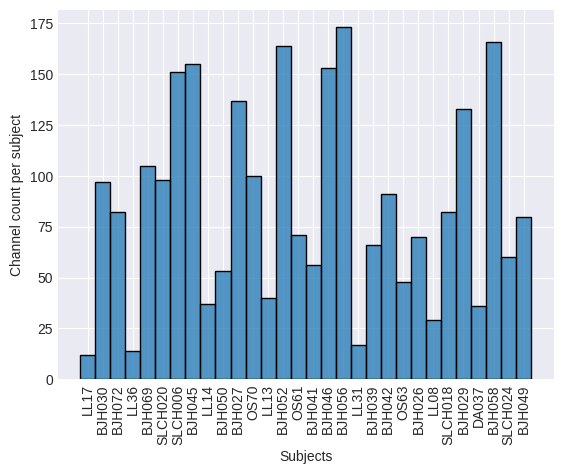

In [10]:
fig, ax = plt.subplots()

sns.histplot(df['subj'], ax=ax)
ax.grid()
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_ylabel('Channel count per subject')
ax.set_xlabel('Subjects')
plt.show()

In [18]:
# FREQ plot 
tfr = []
for subj in subj_included :
    tfr.append(TFRmEvents(subj, data_path = tfr_path))
TFRm =np.concatenate(tfr, axis = 1)

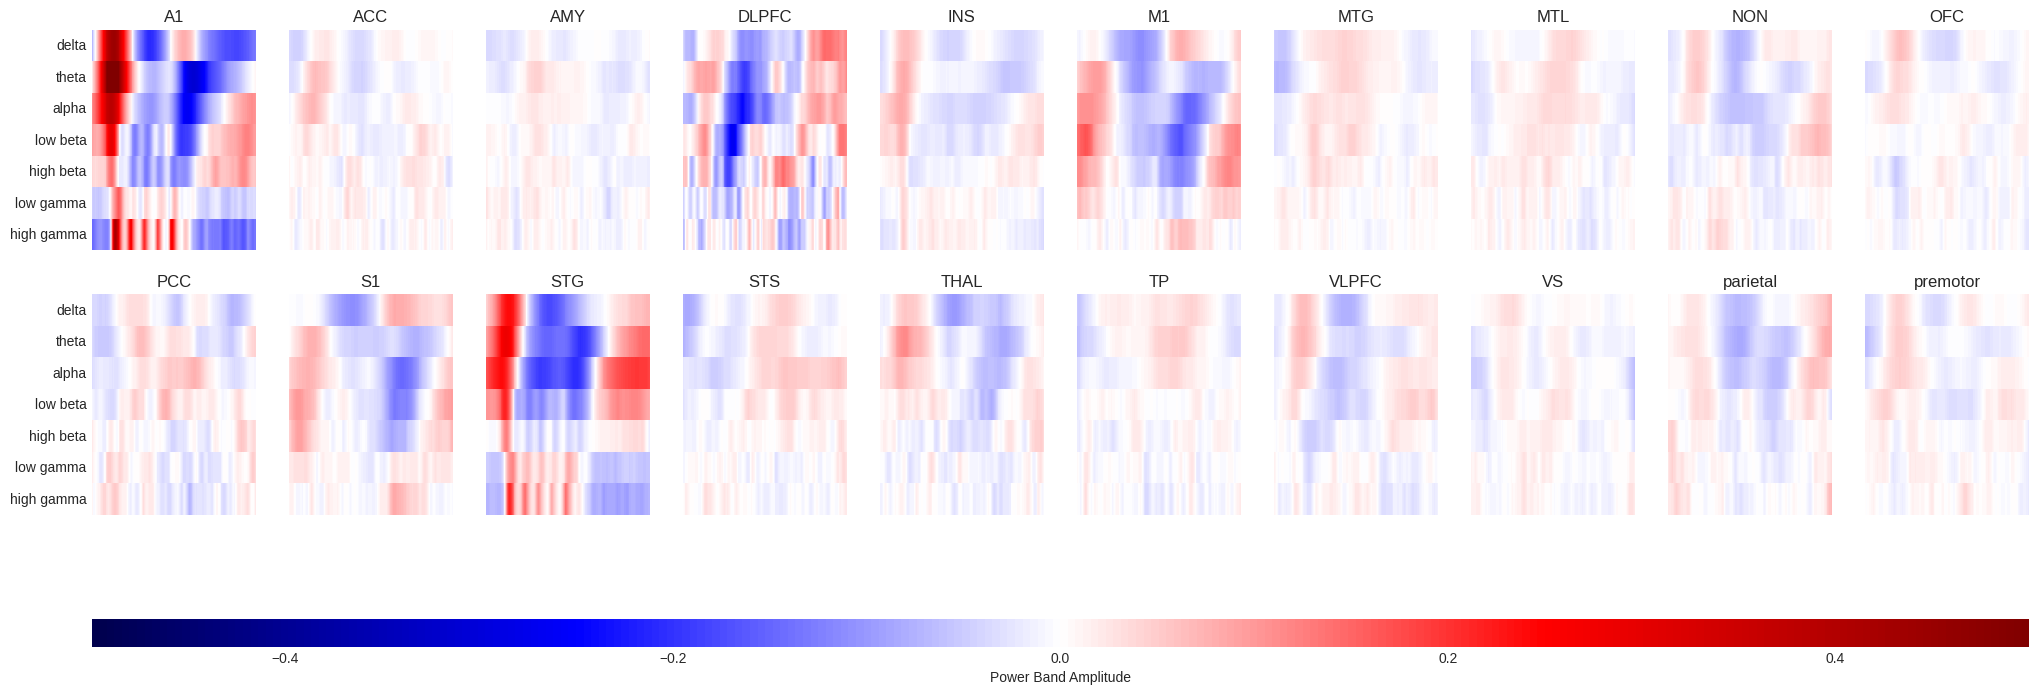

In [26]:
# select each region
hm_list = []
from utils import FREQ_BAND
fig, axs= plt.subplots(2, int(len(np.unique(df.region))/2), figsize = (25, 9), sharey=True)

for r, ax in zip(np.unique(df.region), axs.flatten()) : #['A1']
    id_r = df[df['region'] == r ].index
    tfrm_r = TFRm[0, id_r, :, :].mean(axis=0)
    hm = sns.heatmap(tfrm_r, ax=ax,cbar=False, cmap = 'seismic', vmin = -0.5, vmax = 0.5, xticklabels=False)
    hm_list.append(hm)
    ax.set_title(r)
    ax.grid()
    ax.set_yticklabels([f.replace('_', ' ') for f in FREQ_BAND], rotation = 0)

cbar = fig.colorbar(hm_list[-1].collections[-1], ax=axs, orientation='horizontal',  aspect=70)
cbar.set_label("Power Band Amplitude")
    

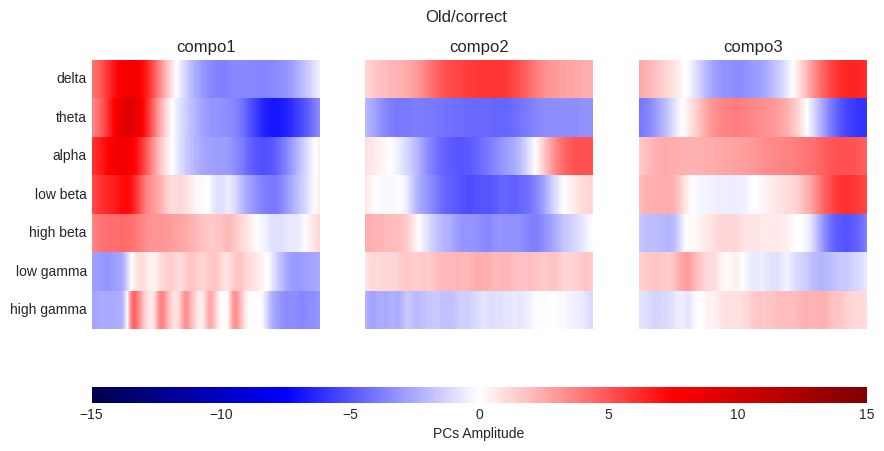

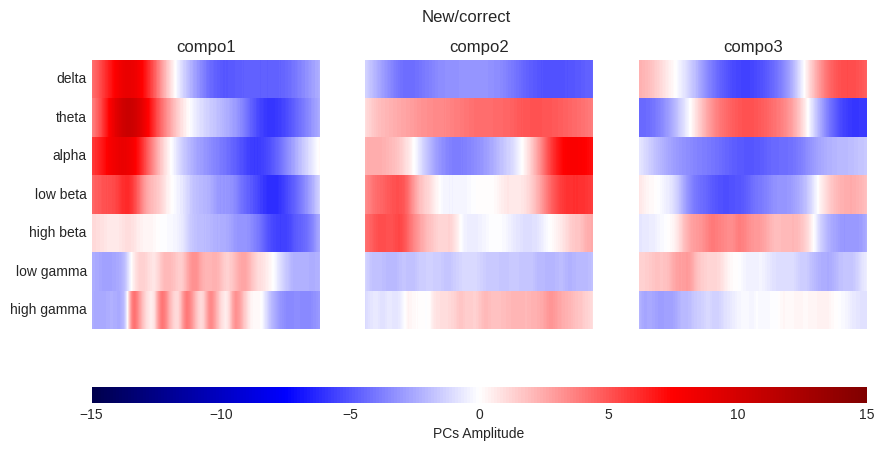

In [30]:
df_pc = pd.read_csv(OUT_PATH + '/grpPCA/supsubj_concat/grp_concat_Xtrans_PCA3.csv').drop(columns = ['Unnamed: 0', 'subj', 'freq', 'expl_var'])
fig, ax= plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)
fig.suptitle('Old/correct')

for i, pc in enumerate(np.unique(df_pc['compo'])) : 
    df_sub = df_pc[df_pc['compo'] == pc].drop(columns = 'compo').values
    hm = sns.heatmap(df_sub[:,:int(df_sub.shape[1]/2 )], ax=ax[i],cbar=False, cmap = 'seismic', vmin = -15, vmax = 15, xticklabels=False)
    hm_list.append(hm)
    ax[i].set_title(pc)
    ax[i].set_yticklabels([f.replace('_', ' ') for f in FREQ_BAND], rotation = 0)

cbar = fig.colorbar(hm_list[-1].collections[-1], ax=ax, orientation='horizontal',  aspect=50)
cbar.set_label("PCs Amplitude")

fig, ax= plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)
fig.suptitle('New/correct')
hm_list = []
for i, pc in enumerate(np.unique(df_pc['compo'])) : 
    df_sub = df_pc[df_pc['compo'] == pc].drop(columns = 'compo').values
    hm = sns.heatmap(df_sub[:,int(df_sub.shape[1]/2 ):], ax=ax[i],cbar=False, cmap = 'seismic', vmin = -15, vmax = 15, xticklabels=False)
    hm_list.append(hm)

    ax[i].set_yticklabels([f.replace('_', ' ') for f in FREQ_BAND], rotation = 0)
    ax[i].set_title(pc)
cbar = fig.colorbar(hm_list[-1].collections[-1], ax=ax, orientation='horizontal',  aspect=50)
cbar.set_label("PCs Amplitude")


## PCA PIPLINE PLOT INTRO

### Baseline adjustement

In [13]:
import pickle
event_ids = [1, 2]
baseline_mean_list = {}
mean_trials_baseline_list={}
list_ = {}
for subj in subj_included[:3] : 
    info_file = f'{OUT_PATH}/Data/{subj}_info.json'
    with open(info_file) as f:
        info = json.load(f)
        time = info['time_tfr']
        events_index = np.array([int(i) for i in info['event_id']])

    with open(f'{OUT_PATH}/Data/{subj}_TFRtrials.p', "rb") as f:
        TFRtrials = pickle.load(f)

    TFRm = np.zeros((len(event_ids), TFRtrials.shape[1], TFRtrials.shape[2], TFRtrials.shape[3]))
 
    for i, ev_id in enumerate(event_ids) :
        index_condi = list(np.where(events_index == ev_id)[0])
        TFRm[i, :,:, :] = TFRtrials[np.array(index_condi), :,:,:].mean(0)

    baseline_end = int(time.index([t for t in time if t>=-0.5][0]))
    mean_baseline = TFRm[:, :, 6, :baseline_end].mean(axis=-1, keepdims=True)
    mean_trials_baseline = TFRtrials[:, :, 6,:baseline_end].mean(axis=-1, keepdims=False)
    baseline_mean_list[subj] = mean_baseline[:,:,0]
    mean_trials_baseline_list[subj] = mean_trials_baseline

    # Baseline adjustement 
    TFRm_ad = TFRm[:, :, 6, :] - mean_baseline
    mean_baseline_ad = TFRm_ad[:, :, :baseline_end].mean(axis=-1, keepdims=False)
    list_[subj] = mean_baseline_ad

FileNotFoundError: [Errno 2] No such file or directory: 'outs/Data/LL17_info.json'

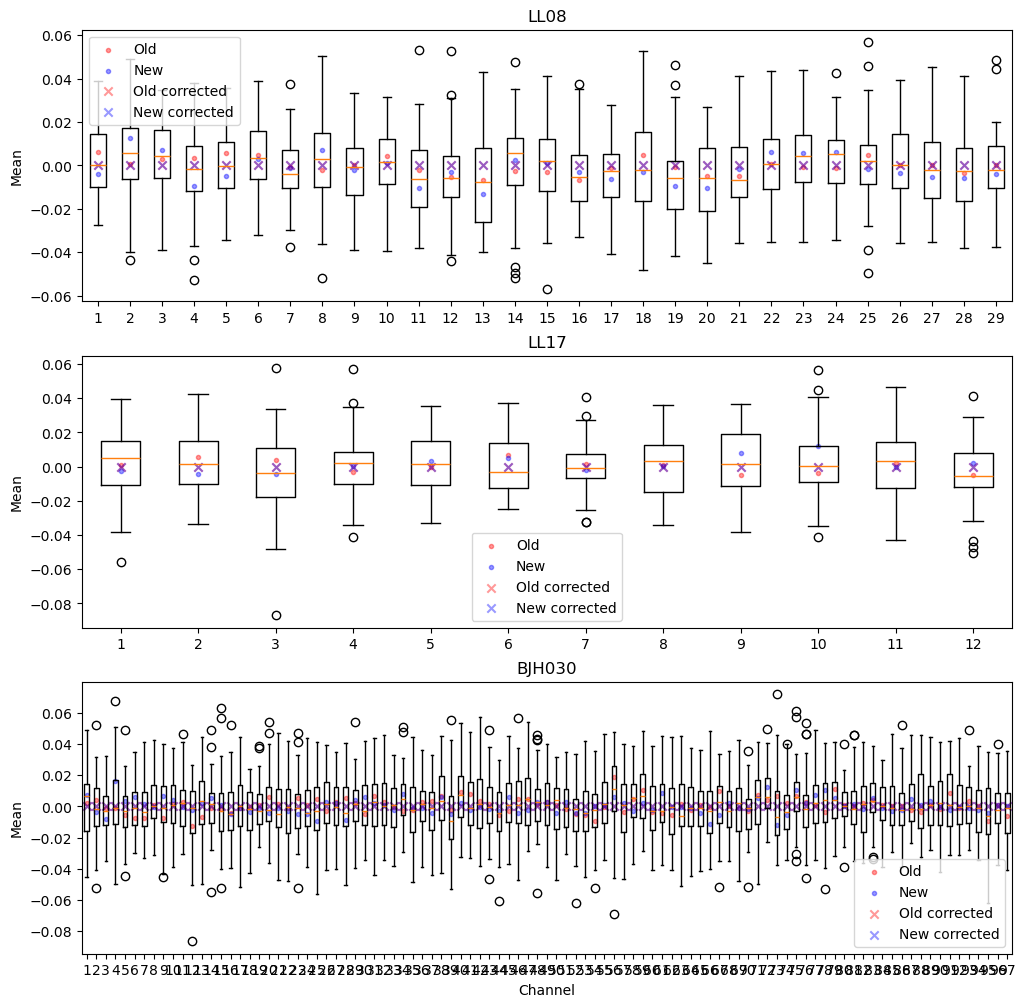

In [ ]:
n_sub = len(mean_trials_baseline_list)
fig, axes = plt.subplots(n_sub, 1, figsize=(12, 4 * n_sub), sharex=False)

for ax, (subj, arr) in zip(axes, mean_trials_baseline_list.items()):
    ax.boxplot([arr[:, ch] for ch in range(arr.shape[1])])
    mean_baseline = baseline_mean_list[subj]
    ax.scatter(np.arange(start = 1, stop =arr.shape[1]+1), mean_baseline[0, :], label='Old', color = 'r', alpha = 0.4,marker='.')
    ax.scatter(np.arange(start=1, stop=arr.shape[1]+1), mean_baseline[1, :], label = 'New', color='b', alpha = 0.4, marker='.')

    ax.scatter(np.arange(start = 1, stop =arr.shape[1]+1), list_[subj][0, :], label='Old corrected', color = 'r', marker='x', alpha = 0.4)
    ax.scatter(np.arange(start=1, stop=arr.shape[1]+1), list_[subj][1, :], label = 'New corrected', color='b', marker='x', alpha = 0.4)
    ax.set_title(subj)
    ax.set_ylabel("Mean")
    ax.legend()
axes[-1].set_xlabel("Channel")
plt.show()

### centering


In [2]:
list_ = []
list_not_adjusted = []
subj_list = []
for subj in subj_included: 
    TFRm = TFRmEvents(subj, data_path=tfr_path)
    # Normalization with baseline  
    with open(tfr_path + f'/{subj}_info.json') as json_data:
        d = json.load(json_data)
        time = d['time_tfr']
        ch_name = d['chnames']
        json_data.close()


    subj_list.extend([subj] * len(ch_name))

    baseline_end = int(time.index([t for t in time if t>0][0]))
    mean_baseline = TFRm[:, :, :, :baseline_end].mean(axis=-1, keepdims=True)
    TFRm_baseline = TFRm-mean_baseline
    list_.append(TFRm_baseline)

list_all = np.concatenate(list_, axis=1)

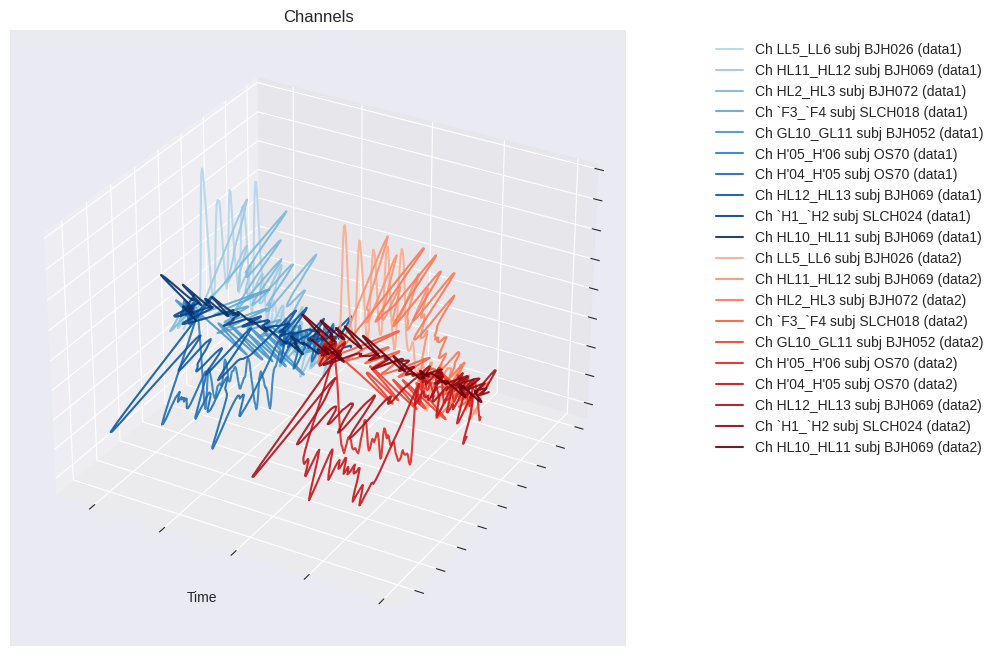

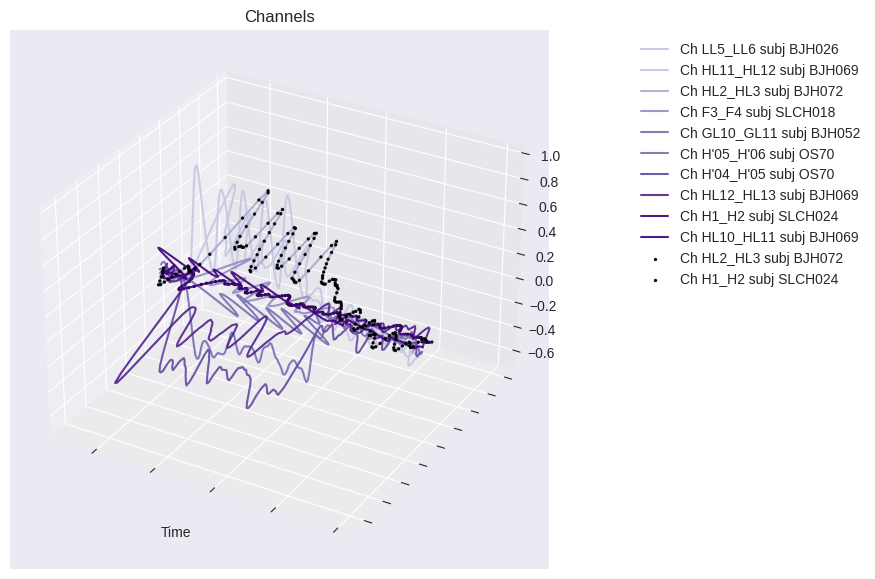

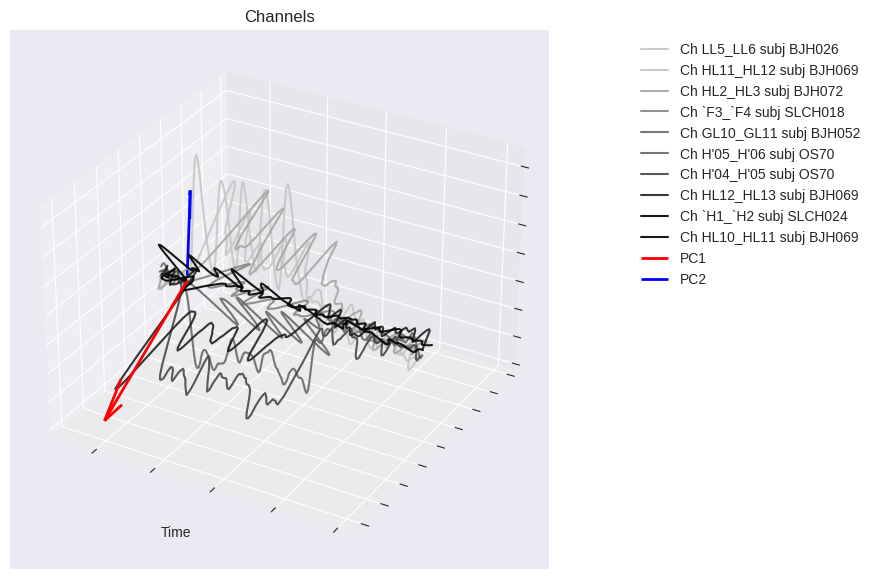

In [3]:
# select a subset of channels
a1 = np.array([a[0] for a in areas])
random.seed(42)
idx_a1 = np.where(a1 == 'A1')[0]
rnd_index_to_pick = random.sample(list(idx_a1), 10)
elects = np.array(elect_list)[rnd_index_to_pick]
subjs = np.array(subj_list)[rnd_index_to_pick]

data1  = list_all[0, rnd_index_to_pick, 6, :]
data2  = list_all[1, rnd_index_to_pick, 6, :]

from utils import PolarChannelSequential, PolarChannel, PolarChannelWithPCA, PolarChannelPloty
concat = np.concat([data1, data2], axis=-1)
PolarChannelSequential(data1, data2, elects=elects, subjs = subjs, data_path = tfr_path)
PolarChannel(list_all[:, rnd_index_to_pick, 6, :].mean(axis=0), elects=elects, subjs = subjs, cmap_name='Purples', to_black=[2, 8], data_path = tfr_path)
datac = list_all[:, :, 6, :].mean(0) - list_all[:, :, 6, :].mean(0).mean(0, keepdims = True)
#PolarChannel(datac[rnd_index_to_pick, :], elects=elects, subjs = subjs, cmap_name='Greens', to_black=[2, 8], data_path = tfr_path)
PolarChannelWithPCA(datac[rnd_index_to_pick, :], elects=elects, subjs = subjs, cmap_name='Greys', data_full = datac, idx_picks=rnd_index_to_pick, data_path = tfr_path)
#PolarChannelPloty(list_all[:, rnd_index_to_pick, 6, :].mean(axis=0), elects=elects, subjs = subjs, data_path = tfr_path)

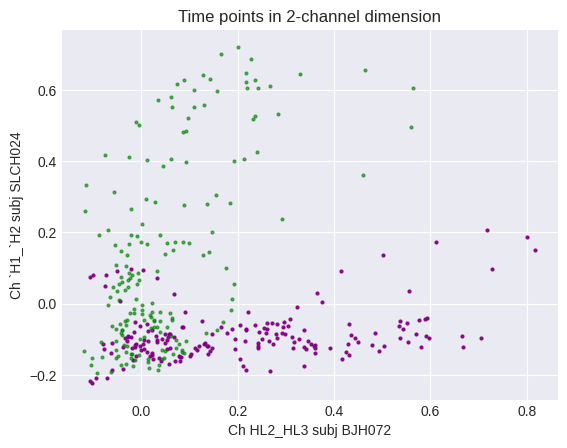

In [4]:
datac = list_all[:, :, 6, :].mean(0) - list_all[:, :, 6, :].mean(0).mean(0, keepdims = True)
data= list_all[:, [rnd_index_to_pick[2], rnd_index_to_pick[8]], 6, :].mean(axis=0)

fig, ax = plt.subplots()
ax.scatter(data[0, :], data[1, :],s=4, label='Not Channel-Centred', color = 'purple', alpha = 0.9)
ax.set_xlabel(f'Ch {elects[2]} subj {subjs[2]}')
ax.set_ylabel(f'Ch {elects[8]} subj {subjs[8]}')
ax.set_title('Time points in 2-channel dimension')

# centering
data_c = datac[rnd_index_to_pick[3:5], :]
ax.scatter(data_c[0, :], data_c[1, :],s=4, color='green', label = 'Channel-Centered', alpha = 0.6)
ax.set_xlabel(f'Ch {elects[2]} subj {subjs[2]}')
ax.set_ylabel(f'Ch {elects[8]} subj {subjs[8]}')
ax.set_title('Time points in 2-channel dimension')
ax.grid()

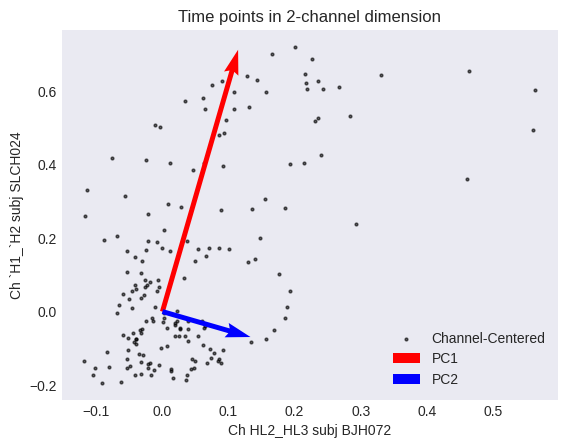

In [5]:
datac = list_all[:, :, 6, :].mean(0) - list_all[:, :, 6, :].mean(0).mean(0, keepdims = True)

data= list_all[:, [rnd_index_to_pick[2], rnd_index_to_pick[8]], 6, :].mean(axis=0)

# centering 
data_c = datac[rnd_index_to_pick[3:5], :]
plt.scatter(data_c[0, :], data_c[1, :], s=4, color='black', label = 'Channel-Centered', alpha = 0.6)
plt.xlabel(f'Ch {elects[2]} subj {subjs[2]}')
plt.ylabel(f'Ch {elects[8]} subj {subjs[8]}')
plt.title('Time points in 2-channel dimension')

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(data_c.T)
components = pca.components_  # shape = (2, 2)
explained_var = pca.explained_variance_  # length 2
scale = 2  # arbitrary scaling for visualization

pc1 = components[0] * np.sqrt(explained_var[0]) * scale
pc2 = components[1] * np.sqrt(explained_var[1]) * scale
origin = np.array([0, 0])  # PCA is computed on centered data
plt.quiver(*origin, pc1[0], pc1[1], color='red', scale=1, width=0.01, label='PC1')
plt.quiver(*origin, pc2[0], pc2[1], color='blue', scale=1, width=0.01, label='PC2')
plt.legend()
